# LSTM

### Obsah<a class='anchor' id='top'></a>
* [Globálne parametre](#1)
* [Načítanie dát](#2)
* [Rozdelenie dát na testovaciu a trénovaciu sadu](#3)
* [Vytvorenie sekvencií](#4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.special import rel_entr
import json
import joblib
import warnings
from joblib import load
warnings.filterwarnings("ignore")

/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Globálne parametre<a class='anchor' id='1'></a>

In [2]:
# Globálne konfiguračné premenné

# Cesty k súborom    
X_PATH = 'X_scaled.npy'
Y_PATH = 'y_labels.npy'
SCALER_PATH = 'scaler.joblib'
FEATURES_PATH = 'selected_features.json'  
UC_MAP_PATH = 'uc_map.json'
CLASS_WEIGHT_PATH = 'class_weights.json'

# Názov stĺpca s cieľovou premennou
LABEL_COLUMN = 'current_uc'       

# Parametre pre rozdelenie dát
TEST_SIZE = 0.2                   
SEED = 42                         

# Parametre pre trénovanie modelu
EPOCHS = 100                       
BATCH_SIZE = 128                   
EARLY_STOP_PATIENCE = 10           
OPTIMIZER = 'adam'                

# Parametre pre LSTM model
SEQUENCE_LENGTH = 60              
LSTM_UNITS = 128                  
DROPOUT_RATE = 0.2                

# Ďalšie parametre
VERBOSE = 1                       

### Načítanie predspracovaných dát <a class='anchor' id='2'></a>

In [3]:
with open(FEATURES_PATH, 'r') as f:
    selected_features = json.load(f)

In [4]:
X_scaled = np.load(X_PATH)
y = np.load(Y_PATH)
scaler = load(SCALER_PATH)

with open(UC_MAP_PATH, "r") as f:
    uc_map = json.load(f)

reverse_uc_map = {v: k for k, v in uc_map.items()}
reverse_uc_map

{0: 'uc1', 1: 'uc2', 2: 'uc3', 3: 'uc4', 4: 'uc5', 5: 'uc6'}

In [5]:
with open(CLASS_WEIGHT_PATH, "r") as f:
    class_weight_dict = json.load(f)

### Rozdelenie dát na trénovaciu a testovaciu množinu <a class='anchor' id='3'></a>

Sliding window funkcia:

In [6]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

#### Vytvorenie sekvencií <a class='anchor' id='4'></a>

In [7]:
# Najprv vytvor sliding windows z celého datasetu
X_seq, y_seq = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

# Potom split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=TEST_SIZE, random_state=SEED, stratify=y_seq
)
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [8]:
print(f"✅ X_train: {X_train.shape}, y_train: {y_train_cat.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test_cat.shape}")

✅ X_train: (35000, 60, 7), y_train: (35000, 6)
✅ X_test: (8750, 60, 7), y_test: (8750, 6)


In [9]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE, restore_best_weights=True)

In [12]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4922 - loss: 1.3197 - val_accuracy: 0.6334 - val_loss: 0.9543
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.6423 - loss: 0.9189 - val_accuracy: 0.6655 - val_loss: 0.8444
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6750 - loss: 0.8329 - val_accuracy: 0.6775 - val_loss: 0.7901
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6862 - loss: 0.7941 - val_accuracy: 0.7093 - val_loss: 0.7225
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7029 - loss: 0.7361 - val_accuracy: 0.7392 - val_loss: 0.6969
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7178 - loss: 0.7035 - val_accuracy: 0.7661 - val_loss: 0.6107
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7482 - loss: 0.6551 - val_accuracy: 0.7376 - val_loss: 0.6361
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7456 - loss: 0.6509 - 

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


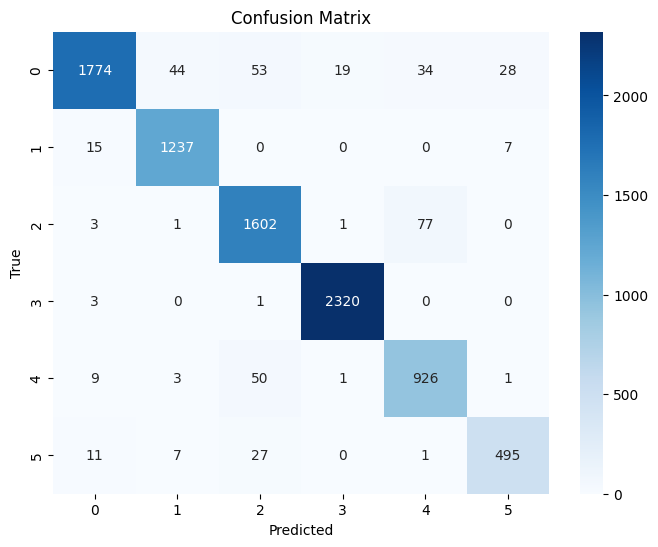

              precision    recall  f1-score   support

           0      0.977     0.909     0.942      1952
           1      0.957     0.983     0.970      1259
           2      0.924     0.951     0.938      1684
           3      0.991     0.998     0.995      2324
           4      0.892     0.935     0.913       990
           5      0.932     0.915     0.924       541

    accuracy                          0.955      8750
   macro avg      0.946     0.949     0.947      8750
weighted avg      0.956     0.955     0.955      8750



In [13]:
# Predikcia

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))

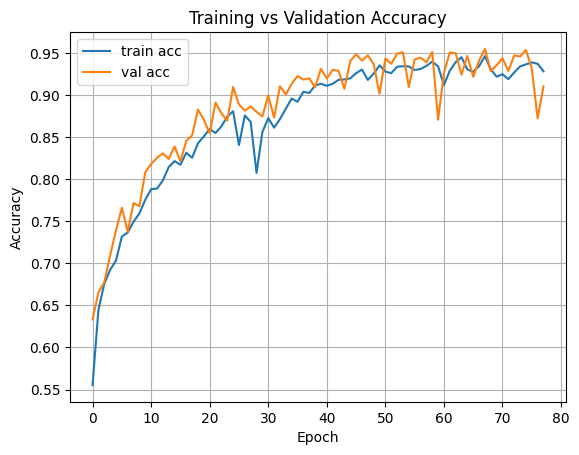

In [14]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
def build_improved_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.3):
    """
    Vylepšený LSTM model:
    - 2 LSTM vrstvy (druhá menšia)
    - Dropout po každej vrstve
    - Hustá (dense) vrstva pred výstupom
    """
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 4))
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate / 2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model2 = build_improved_lstm_model((SEQUENCE_LENGTH, X_train.shape[2]), num_classes, lstm_units=128, dropout_rate=0.1)

In [17]:
history = model2.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.4892 - loss: 1.3431 - val_accuracy: 0.6231 - val_loss: 0.9174
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6360 - loss: 0.9171 - val_accuracy: 0.6653 - val_loss: 0.8462
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.6715 - loss: 0.8350 - val_accuracy: 0.6667 - val_loss: 0.8030
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.6657 - loss: 0.8216 - val_accuracy: 0.6962 - val_loss: 0.7400
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.6829 - loss: 0.7783 - val_accuracy: 0.7058 - val_loss: 0.7194
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.7076 - loss: 0.7201 - val_accuracy: 0.7037 - val_loss: 0.7165
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.7107 - loss: 0.7188 - val_accuracy: 0.7281 - val_loss: 0.6669
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.7272 - loss: 0

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


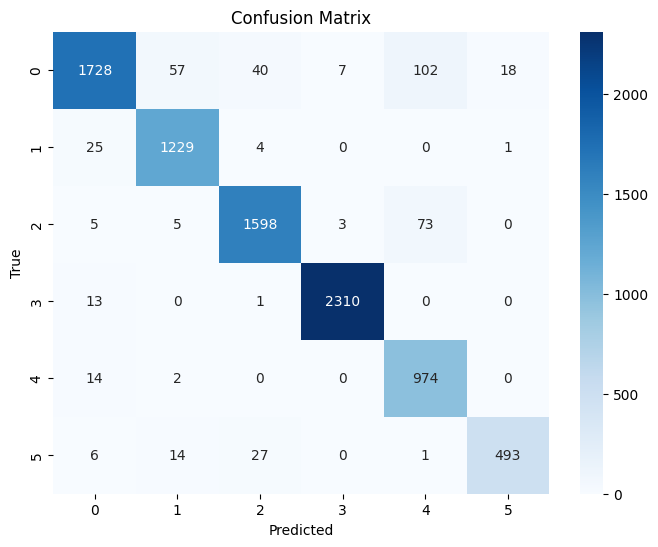

              precision    recall  f1-score   support

           0      0.965     0.885     0.923      1952
           1      0.940     0.976     0.958      1259
           2      0.957     0.949     0.953      1684
           3      0.996     0.994     0.995      2324
           4      0.847     0.984     0.910       990
           5      0.963     0.911     0.936       541

    accuracy                          0.952      8750
   macro avg      0.945     0.950     0.946      8750
weighted avg      0.955     0.952     0.952      8750



In [18]:
y_pred = model2.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))

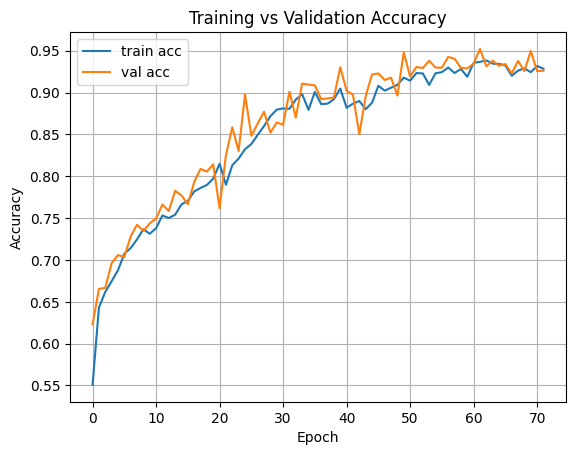

In [19]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.5148 - loss: 1.2387 - val_accuracy: 0.6503 - val_loss: 0.9024
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6697 - loss: 0.8327 - val_accuracy: 0.7121 - val_loss: 0.7243
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.7130 - loss: 0.7082 - val_accuracy: 0.7466 - val_loss: 0.6322
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.7253 - loss: 0.6608 - val_accuracy: 0.7677 - val_loss: 0.5916
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.7525 - loss: 0.5992 - val_accuracy: 0.7735 - val_loss: 0.5293
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.7728 - loss: 0.5457 - val_accuracy: 0.8232 - val_loss: 0.4944
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.7880 - loss: 0.5143 - val_accuracy: 0.8170 - val_loss: 0.4443
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.7977 - loss: 0

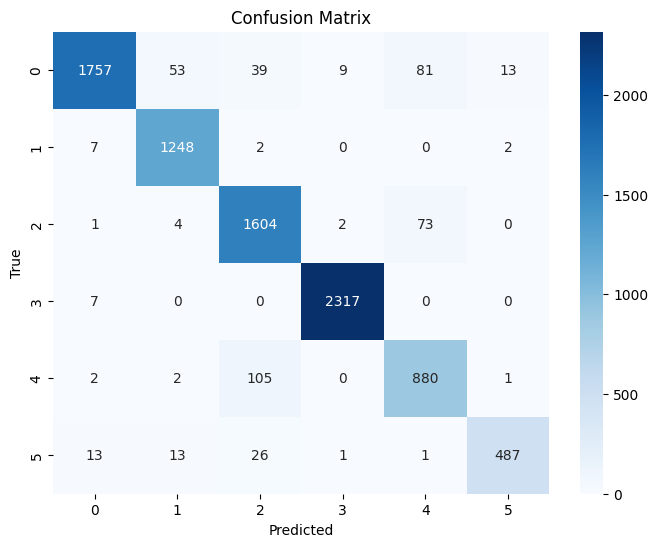

              precision    recall  f1-score   support

           0      0.983     0.900     0.940      1952
           1      0.945     0.991     0.968      1259
           2      0.903     0.952     0.927      1684
           3      0.995     0.997     0.996      2324
           4      0.850     0.889     0.869       990
           5      0.968     0.900     0.933       541

    accuracy                          0.948      8750
   macro avg      0.941     0.938     0.939      8750
weighted avg      0.949     0.948     0.948      8750



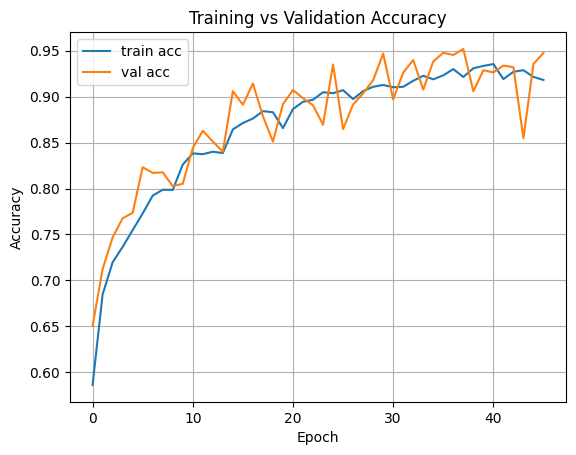

In [21]:
def build_batchnorm_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(lstm_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate / 2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model3 = build_batchnorm_lstm_model((SEQUENCE_LENGTH, X_train.shape[2]), num_classes, lstm_units=128, dropout_rate=0.1)
history = model3.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)
y_pred = model3.predict(X_test).argmax(axis=1)
y_true = y_test
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Vlastná Attention vrstva (kompatibilná s LSTM výstupom)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # Výpočet skóre
        a = K.softmax(e, axis=1)               # Normovanie cez čas
        output = x * a                         # Vážený súčin
        return K.sum(output, axis=1)           # Výstup ako kontextový vektor

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Model s Attention
def build_attention_lstm_model(input_shape, num_classes, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=input_shape)
    x = LSTM(lstm_units, return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units // 2, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    attention = AttentionLayer()(x)  # Tu sa aplikuje attention
    dense1 = Dense(64, activation='relu')(attention)
    drop1 = Dropout(dropout_rate)(dense1)
    outputs = Dense(num_classes, activation='softmax')(drop1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model4 = build_attention_lstm_model((SEQUENCE_LENGTH, X_train.shape[2]), num_classes)
model4.summary()

history = model4.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

In [ ]:
y_pred = model4.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Klasifikačný report
print(classification_report(y_true, y_pred, digits=3))

In [22]:
data = pd.read_csv("../real_data.csv")
scaler = joblib.load("scaler.joblib")
model = model3

In [ ]:
data[LABEL_COLUMN] = data[LABEL_COLUMN].map(uc_map)
data[LABEL_COLUMN] = data[LABEL_COLUMN] - 1

APP_MAP = {'0': 0, 'amf': 1, 'gmm': 2, 'udm': 3, 'smf': 4, 'upf': 5}
LOG_MAP = {'0': 0, 'registration': 1, 'number_of_sessions_or_ues': 2,
           'nothing': 3, 'remove': 4, 'error': 5 }

data["application"] = data["application"].map(APP_MAP)
data["log_type"] = data["log_type"].map(LOG_MAP)

In [ ]:
X = data[selected_features['features']].values
y = data[LABEL_COLUMN].values
X_scaled = scaler.transform(X)

In [ ]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_real_seq, y_real_seq = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

In [ ]:
y_pred_probs = model.predict(X_real_seq)
y_pred = y_pred_probs.argmax(axis=1)

In [ ]:
print(classification_report(y_real_seq, y_pred, digits=3))

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_real_seq, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Real Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [27]:
# Uložíme model
model.save("lstm_model_batchnorm.h5")
model.save("Model_bn.keras")


In [ ]:
model_batch = load_model("lstm_model_batchnorm.h5")

for layer in model_batch.layers[:-3]:  # zmraz všetky okrem posledných 3
    layer.trainable = False


In [ ]:
real_data = pd.read_csv("../real_data.csv")

real_data['application'] = real_data['application'].map(APP_MAP)
real_data['log_type'] = real_data['log_type'].map(LOG_MAP)
real_data['current_uc'] = real_data['current_uc'].map(uc_map)
real_data[LABEL_COLUMN] = real_data[LABEL_COLUMN] - 1
real_data['timestamp'] = pd.to_datetime(real_data['timestamp'])


In [ ]:
X_real = real_data[selected_features['features']].values
y_real = real_data[LABEL_COLUMN].values

In [ ]:
scaler = load("scaler.joblib")
X_real_scaled = scaler.transform(X_real)

In [ ]:
X_real_seq, y_real_seq = create_sequences(X_real_scaled, y_real, SEQUENCE_LENGTH)


In [ ]:
# Split na malý fine-tune tréning + validáciu
X_ft, X_val, y_ft, y_val = train_test_split(
    X_real_seq, y_real_seq, test_size=0.8, stratify=y_real_seq, random_state=SEED
)

y_ft = y_ft - 1
y_val = y_val - 1

y_ft_cat = to_categorical(y_ft, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [ ]:

model_batch.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model_batch.fit(
    X_ft, y_ft_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,  # málo epoch
    batch_size=64,
    verbose=1,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

In [ ]:
y_real_pred_probs = model_batch.predict(X_real_seq)
y_real_pred = np.argmax(y_real_pred_probs, axis=1)
# Report
print(classification_report(y_real_seq, y_real_pred))

# Confusion Matrix
cm = confusion_matrix(y_real_seq, y_real_pred)

# Vizualizácia
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Real Data (after fine-tuning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:


synthetic = pd.read_csv("../synthetic_data.csv")
real = pd.read_csv("../real_data.csv")

synthetic['application'] = synthetic['application'].map(APP_MAP)
synthetic['log_type'] = synthetic['log_type'].map(LOG_MAP)
synthetic['current_uc'] = synthetic['current_uc'].map(uc_map)
synthetic[LABEL_COLUMN] = synthetic[LABEL_COLUMN] - 1

synthetic = synthetic.fillna(synthetic.mode().iloc[0])
real = real.fillna(real.mode().iloc[0])

real['application'] = real['application'].map(APP_MAP)
real['log_type'] = real['log_type'].map(LOG_MAP)
real['current_uc'] = real['current_uc'].map(uc_map)
real[LABEL_COLUMN] = real[LABEL_COLUMN] - 1

# 3. Normalizácia dát
scaler_X = StandardScaler()
selected_features = selected_features['features']
combined = pd.concat([synthetic[selected_features], real[selected_features]])
scaler_X.fit(combined)

synthetic_scaled = scaler_X.transform(synthetic[selected_features])
real_scaled = scaler_X.transform(real[selected_features])

# PCA vizualizácia
pca = PCA(n_components=2)
pca_synthetic = pca.fit_transform(synthetic_scaled)
pca_real = pca.transform(real_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(pca_synthetic[:, 0], pca_synthetic[:, 1], alpha=0.5, label='Synthetic', s=10)
plt.scatter(pca_real[:, 0], pca_real[:, 1], alpha=0.5, label='Real', s=10)
plt.title("PCA: Synthetic vs Real")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

# t-SNE vizualizácia
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(np.concatenate([synthetic_scaled, real_scaled]))
labels = ['synthetic'] * len(synthetic_scaled) + ['real'] * len(real_scaled)

tsne_df = pd.DataFrame(tsne_result, columns=["TSNE1", "TSNE2"])
tsne_df["source"] = labels

plt.figure(figsize=(8, 5))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="source", alpha=0.5, s=12)
plt.title("t-SNE: Synthetic vs Real")
plt.grid(True)
plt.show()

# KL-divergencia (jednotlivo pre každú metriku)
kl_results = {}

for f in selected_features:
    syn_vals = synthetic[f].values
    real_vals = real[f].values

    bins = np.linspace(
        min(syn_vals.min(), real_vals.min()), 
        max(syn_vals.max(), real_vals.max()), 
        100
    )

    hist_syn, _ = np.histogram(syn_vals, bins=bins, density=True)
    hist_real, _ = np.histogram(real_vals, bins=bins, density=True)

    # Laplace smoothing (aby sa vyhli nule)
    hist_syn += 1e-9
    hist_real += 1e-9

    kl_div = np.sum(rel_entr(hist_syn, hist_real))
    kl_results[f] = kl_div

# Výpis výsledkov
kl_df = pd.DataFrame.from_dict(kl_results, orient='index', columns=['KL Divergence']).sort_values(by='KL Divergence', ascending=False)
print("\n📊 KL-divergencia medzi rozloženiami syntetických a reálnych metrík:")
print(kl_df)


In [ ]:
# Budeme používať iba metriky, ktoré majú KL-divergenciu < 5
selected_features = kl_df[kl_df['KL Divergence'] < 5].index.tolist()
print(f"✅ Selected features based on KL divergence: {selected_features}")